# Lecture 1 - Dedalus (v3)

## What is Dedalus?
* Dedalus is an open-source PDE solver written in Python.
* It is parallelised using MPI and is scalable.
* It is a pseudo-spectral solver.
* Domains can be cartesian boxes (potentially bounded in one dimension), or curvilinear (spheres, shells, balls, disks, annuli).
* It is a high-level code, where the equations are inputted in plain text.
* Dedalus can solve eigenvalue problems (EVP), linear boundary value problems (LBVP), nonlinear boundary value problems (NLBVP), and initial value problems (IVP).

## Dedalus - resources
* Dedalus webpage
* Dedalus google users group
* Dedalus tutorials
* Dedalus github (contribute new features via pull requests!)
* Boyd's book on spectral methods.

## Spectral methods
Spectral methods approximate the solution $q$ by approximating it as an expansion in basis functions $\{\phi_n\}_{n=0^N}$ as
$$
q \approx \sum_n a_n \phi_n,
$$
where $a_n$ are solved for such that $q$ is an accurate approximation. Whilst there are many choices of bases functions $\phi_n$, usually the geometry dictates the choice. In Dedalus
* Periodic direction cartesian - Fourier series (real or complex)
* Bounded direction  - Jacobi polynomials $P_n^{a,b}(x)$ $x\in[-1,1]$, orthogonal with respect to the weight $(1-x)^\alpha(1+x)^\beta$ (includes Chebyshev $\alpha=\beta=-1/2$, Legendre $\alpha=\beta=0$, e.t.c
* Sphere - Spherical harmonics $Y_\ell^m$.

## Navier-Stokes in 10 minutes
Consider 2D Kolmogorov-flow. The equations can be written in streamfunction vorticity form as
\begin{eqnarray}
    \frac{\partial \psi}{\partial t} -\nu \nabla^2 \psi = -J(\psi, \omega) + f,
\end{eqnarray}
where $\psi=\nabla^2\omega$. Let's solve this for $(x,y)\in[0,2\pi]^2$ with periodic boundary conditions in Dedalus. The forcing will be specified to be $f=4\cos 4y$.

In [1]:
# Import Dedalus and other libraries
import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging

logger = logging.getLogger(__name__)

As the domain is doubly periodic we can represent the solution using Fourier series in $x$ and $y$. To achieve this in Dedalus we set up a cartesian coordinate system, and represent function in $x$ and $y$ using a real Fourier expansion.

In [2]:
# Bases
coords = d3.CartesianCoordinates('x', 'y')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=128, bounds=(0, 2*np.pi), dealias=3/2)
ybasis = d3.RealFourier(coords['y'], size=128, bounds=(0, 2*np.pi), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)

In creating the bases we have set `dealias=3/2`. This is because a polynomial of degree $sN+n$ will alias down to a polynomial of degree $sN-n$ on a grid of size $sN$ (here $N=128$ and $s$ is the dealiasing factor). For a quadratic nonlinearity, the highest degree polynomial will be $2(N-1)$. We would like no aliasing errors up to degree $N$.

One way to achieve this is to set $s=2$, as then all non-linearities are truncated. However, this is wasteful. Instead of setting $s=2$ so that nothing is aliased, we can instead allow things to be aliased, as long as they are aliased to modes that are then truncated!

The largest $n$ is obtained for $2(N-1)=sN+n$, giving $n=(2-s)N_c-2$. We want this aliased above $N$, and so
require $sN_c-(2-s)N_c+2>N$, or more simply $2sN>3N-2$. This is satisfied for $s>3/2$.

We can then create variables that are represented as expansions in these bases.

In [3]:
psi = dist.Field(name='psi', bases=(xbasis, ybasis)) # psi depends on x and y
f   = dist.Field(name='f', bases=(ybasis)) # f depends on y only!

These fields can be interacted with in a variety of layouts. As the problem is two-dimensional there are three possible layouts. The zeroth is everything in coefficient space, the first is $x$ in coeffient space and $y$ in grid space, and the second is everything in grid space. We can verify this by running

In [4]:
# Print the different layouts
for layout in dist.layouts:
    print(layout.grid_space)

[False False]
[False  True]
[ True  True]


The most common layouts to use are coefficient space and grid space, which can be accessed using the shortcuts `['g']` and `['c']`. For example, to set the forcing function $f$ we can write

Text(0.5, 0, '$n$')

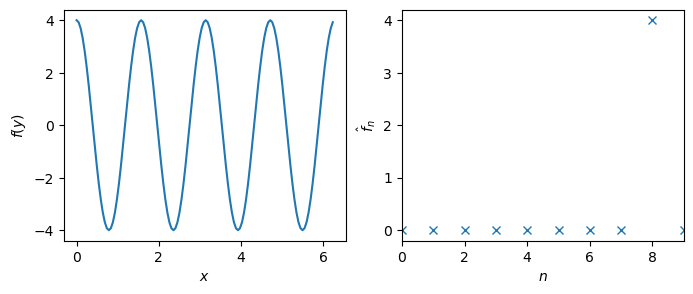

In [5]:
f['g'] = 4*np.cos(4*y)
fig, ax = plt.subplots(1,2, figsize=(8,3))
ax[0].plot(y.squeeze(), f['g'].squeeze())
ax[1].plot(f['c'].squeeze(), 'x')
ax[1].set_xlim([0,9])
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f(y)$')
ax[1].set_ylabel(r'$\hat{f}_n$')
ax[1].set_xlabel(r'$n$')

We see that in coefficient space $f$ has just a single component in the eighth position of the array. This is because Dedalus stores the spectral coefficients for a real Fourier basis as follows
`[cos(0y), -sin(0y), cos(1y), -sin(1y),...]`. Hence, the $\cos 4y$ component is in the eighth position.

Fields in Dedalus can be operated on using operators. For example, we can specify the calculus operators we need as

In [6]:
dx = lambda A: d3.Differentiate(A, coords['x'])
dy = lambda A: d3.Differentiate(A, coords['y'])
J  = lambda A, B: dx(A)*dy(B) - dy(A)*dx(B)

We can also use operators to perform substitutions. Using this we can set the vorticity in terms of the streamfunction directly as

In [7]:
omega = d3.lap(psi)

Dedalus uses defered evaluation to evaluate expressions. For example consider the bracket term; plotting the operator shows that this is evaluated entirely in terms of $\psi$. In other words, everytime we ask for this term it will create it using the current field data governing $\psi$.

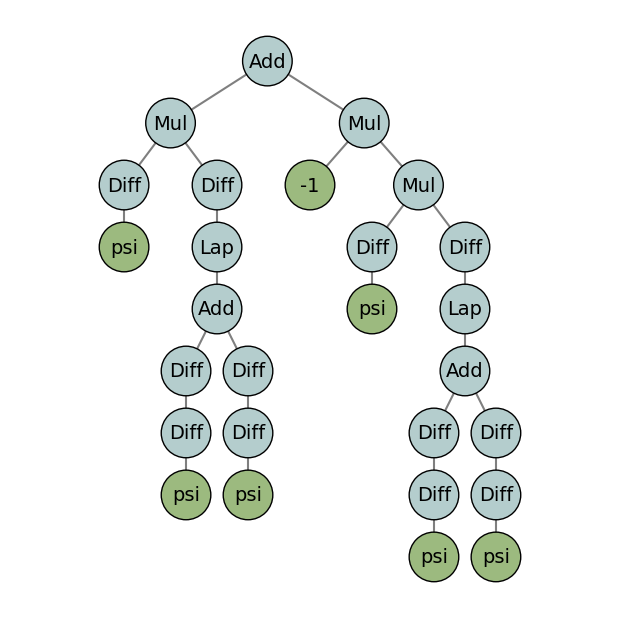

In [8]:
from dedalus.tools.plot_op import plot_operator
plot_operator(J(psi, omega), figsize=6, fontsize=14, opsize=0.4)

We can evaluate operators and use them like fields. Writing `omega['g']`, will calculate $\omega$ from $\psi$ and give access to its grid data as a numpy array. If we want a field that is not updated, but is the vorticity for the current streamfunction we can instead write `omega_current = omega.evauate()`. This gives a field `omega_current` that will not update.

Our initial value problem can now be written as

In [9]:
nu = 0.025
tau_psi = dist.Field(name='tau_psi')
# Problem
problem = d3.IVP([psi, tau_psi], namespace=locals())
problem.add_equation("dt(omega) - nu*lap(omega) + tau_psi = -J(psi,omega) + f")
problem.add_equation("integ(psi) = 0");

When writing an initial value problem in Dedalus, the LHS is timestepped implicitly and the RHS is timestepped explicitly. This means that the LHS needs to be linear in the problem variables, and nonlinearities must be on the RHS.
The constant field `tau_psi` is introduced to eliminate a gauge freedom. The gauge freedom arises becauuse the streamfunction `psi` is defined up to a consant factor. This gauge freedom comes paired with a redundant equation. Indeed, in spectral space the LHS of the first equation is always zero for the $k_x=k_y=0$ mode. This makes the linear system for timestepping singular, even though the RHS is also always zero for the $k_x=k_y=0$ mode. This redundant equation can be removed by simply adding a constant field `tau_psi` to the LHS. This modifies the $k_x=k_y=0$ equation from `0=0` to `tau_psi=0`, removing the singularity. This extra degree of freedom requires us to add one extra consant equation. This is that the integral of `psi` is zero, which sets the gauge choice.

With the problem specified, a solver for the initial value problem can be built for a given timestepper. Dedalus has a range of implicit-explicit timesteppers available. Here we use a second order Runge-Kutta scheme.

In [10]:
solver = problem.build_solver(d3.RK222)

2024-07-17 14:33:50,903 subsystems 0/1 INFO :: Building subproblem matrices 1/64 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 2.7e+01/s
2024-07-17 14:33:51,001 subsystems 0/1 INFO :: Building subproblem matrices 7/64 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.2e+01/s
2024-07-17 14:33:51,111 subsystems 0/1 INFO :: Building subproblem matrices 14/64 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 5.7e+01/s
2024-07-17 14:33:51,221 subsystems 0/1 INFO :: Building subproblem matrices 21/64 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s
2024-07-17 14:33:51,337 subsystems 0/1 INFO :: Building subproblem matrices 28/64 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.0e+01/s
2024-07-17 14:33:51,457 subsystems 0/1 INFO :: Building subproblem matrices 35/64 (~55%) Elapsed: 1s, Remaining: 0s, Rate: 5.9e+01/s
2024-07-17 14:33:51,565 subsystems 0/1 INFO :: Building subproblem matrices 42/64 (~66%) Elapsed: 1s, Remaining: 0s, Rate: 6.0e+01/s
2024-07-17 14:33:51,676 subsystems 0/1 INFO :: Building subproblem matri

In [11]:
u_vec = d3.skew(d3.grad(psi)) 
CFL = d3.CFL(solver, initial_dt=1e-1, cadence=10, safety=0.8, threshold=0.1,
             max_change=1.5, min_change=0.5, max_dt=1e-1)
CFL.add_velocity(u_vec)

We can now specify an initial condition, and timestep the problem until $T=1$.

In [12]:
psi.fill_random(layout='c')
psi.low_pass_filter(scales=0.25)
psi['g'] *= 1e-3
solver.stop_sim_time = 20
timestep = 1e-3
# Monitor KE
flow = d3.GlobalFlowProperty(solver, cadence=100)
flow.add_property(0.5*u_vec@u_vec, name='KE')
KE_list = []
times = []
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if((solver.iteration-1) % 100 ==0 ):
            KE = flow.volume_integral('KE')/(2*np.pi)**2
            KE_list.append(KE)
            times.append(solver.sim_time)
            logger.info('Iteration=%i, Time=%e, dt=%e, KE=%e' %(solver.iteration, solver.sim_time, solver.dt, KE))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-07-17 14:33:51,981 __main__ 0/1 INFO :: Starting main loop
2024-07-17 14:33:52,395 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-01, dt=1.000000e-01, KE=1.893526e-02
2024-07-17 14:33:54,418 __main__ 0/1 INFO :: Iteration=101, Time=3.617298e+00, dt=2.148392e-02, KE=9.084452e-01
2024-07-17 14:33:56,105 __main__ 0/1 INFO :: Iteration=201, Time=5.215766e+00, dt=1.209171e-02, KE=1.111461e+00
2024-07-17 14:33:57,558 __main__ 0/1 INFO :: Iteration=301, Time=6.471598e+00, dt=1.364708e-02, KE=6.322147e-01
2024-07-17 14:33:58,995 __main__ 0/1 INFO :: Iteration=401, Time=7.933986e+00, dt=1.527509e-02, KE=5.830365e-01
2024-07-17 14:34:00,659 __main__ 0/1 INFO :: Iteration=501, Time=9.461495e+00, dt=1.527509e-02, KE=5.929551e-01
2024-07-17 14:34:02,198 __main__ 0/1 INFO :: Iteration=601, Time=1.078347e+01, dt=1.207937e-02, KE=6.068306e-01
2024-07-17 14:34:03,784 __main__ 0/1 INFO :: Iteration=701, Time=1.201942e+01, dt=1.347977e-02, KE=6.080504e-01
2024-07-17 14:34:05,251 __main__ 0/1 INFO 

Text(0, 0.5, '$KE$')

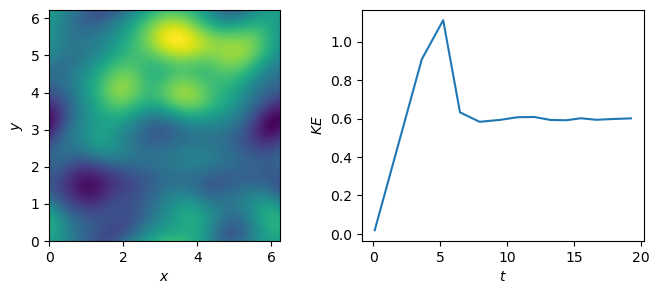

In [13]:
psi.change_scales(1)
fig, ax = plt.subplots(1, 2, figsize=(8,3))
ax[0].contourf(x.squeeze(), y.squeeze(), psi['g'].T,100)
ax[1].plot(times, KE_list)
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$y$')
ax[0].set_aspect('equal')

ax[1].set_xlabel(r'$t$')
ax[1].set_ylabel(r'$KE$')

Although this example runs quickly in this jupyter notebook, it can also be run in parallel. For an $N$-dimensional problem, Dedalus parallelises over the first $N-1$ dimensions. Running this in parallel out of the notebook gives the following video.

## What about walls?

Now let's consider a problem with walls, namely plane Poiseuille flow (pressure driven flow through a channel). The governing equations are 
\begin{eqnarray}
    \frac{\partial \mathbf{u}}{\partial t} + \mathbf{u}\cdot\nabla\mathbf{u} &=& -\nabla P + \frac{1}{Re}\nabla^2\mathbf{u},\\
    \nabla\cdot\mathbf{u} &=&0.
\end{eqnarray}
A constant pressure gradient $p_0=2x/\textit{Re}$ maintains the base-flow $\mathbf{u}_0=1-y^2$.

In [14]:
coords = d3.CartesianCoordinates('x', 'y')
dist   = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=64, bounds=(0, 2*np.pi), dealias=3/2)
ybasis = d3.Chebyshev(coords['y'], size=64, bounds=(-1, 1), dealias=3/2)
x, y   = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist)

## Sparsity

Dedalus uses sparse spectral methods. To illustrate this let's look at the bases in the $y$ direction in more detail.

In [15]:
print(ybasis)

Jacobi(y, 64, a0=-0.5, b0=-0.5, a=-0.5, b=-0.5, dealias=1.5)


(0.0, 5.0)

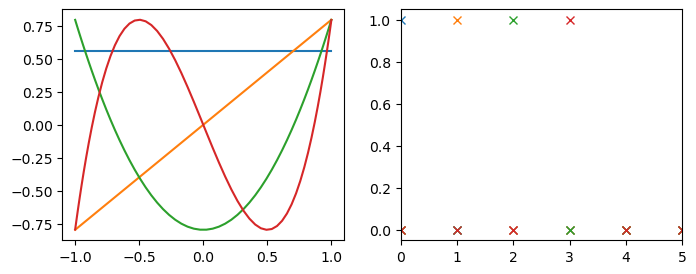

In [16]:
T_polys = dist.Field(name='T_polys', bases=ybasis)
fig, ax = plt.subplots(1, 2, figsize=(8,3))
for i in range(4):
    T_polys['c'] *= 0
    T_polys['c'][0,i] = 1
    ax[0].plot(y.squeeze(), T_polys['g'].squeeze())
    ax[1].plot(T_polys['c'].squeeze(),'x')
ax[1].set_xlim([0,5])

We see that the `ybasis` is actually a Jacobi basis with $a=b=-1/2$, corresponding to Chebyshev-T polynomials $T_n$. The derivative of a Chebshev-T polynomial is given through the equation
$$
\frac{\textrm{d} T_n(x)}{\textrm{d} x} = \sum_{i=0}^{n-1}T_i(x)\frac{2j((j-1)\;\textrm{mod}\;2)}{1+\delta_{i,0}}.
$$
Simply put, the derivative of a single Chevyshev-T polynomial of degree $n$ is a sum of all the Chebyshev polynomials with degree up to $n-1$. This results in a dense operation. Let's now see what happens in Dedalus when we differentiate Chebyshev-T polynomials,

(0.0, 5.0)

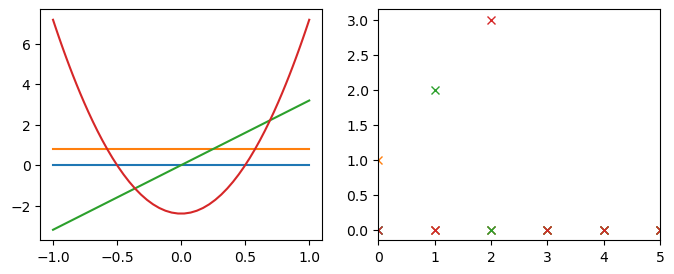

In [17]:
# Now consider 
Tpoly_deriv = d3.Differentiate(T_polys, coords['y'])
fig, ax = plt.subplots(1, 2, figsize=(8,3))
for i in range(4):
    T_polys['c'] *= 0
    T_polys['c'][0,i] = 1
    U_polys = Tpoly_deriv.evaluate()
    U_polys.change_scales(1)
    ax[0].plot(y.squeeze(), U_polys['g'].squeeze())
    ax[1].plot(U_polys['c'].squeeze(),'x')
ax[1].set_xlim([0,5])

We see that the result is sparse in coefficient space. This can be explained by examining the coefficients of the derivative of a field defined on the Chebyshev-T basis.

In [18]:
print(Tpoly_deriv.domain.bases[0])

Jacobi(y, 64, a0=-0.5, b0=-0.5, a=0.5, b=0.5, dealias=1.5)


The basis now has $a=b=1/2$ which corresponds to Chebyshev-U polynomials $U_n(x)$. This is done because we can rewrite our differentiation rule for Chebyshev-T polynomials as
$$
\frac{\textrm{d} T_n(x)}{\textrm{d} x} = nU_{n-1}(x),
$$
showing that the derivative is sparse in terms of Chebyshev U polynomials. Taking further derivatives results in other bases with higher $a$'s and $b$'s, mainaining sparsity for differential operators.

In [19]:
# Now proceed to solve the IVP
Re = 2000
u = dist.VectorField(coords, name='u', bases=(xbasis, ybasis))
u0 = dist.VectorField(coords, name='u0', bases=(ybasis))
u0['g'][0] = 1-y**2
p = dist.Field(name='p', bases=(xbasis, ybasis))
p0_grad = dist.VectorField(coords, name='p0_grad')
p0_grad['g'][0] = 2/Re

## Boundary conditions and the tau-method

In the $y$-direction we are seeking a polynomial expansion for the solution. If we take the ODE
$\frac{d q}{dy}=q$, with $q(0)=1$, the solution is 
$$
q = e^y = \sum_i \frac{y^i}{i!}.
$$
This is not expressible as a finite sum of polynomials. Instead consider the perturbed problem $\frac{d q}{dy}=q + \tau y^p$ and see a solution in the form
$$
q = \sum_i a_i y^i.
$$
Substituting this in and equating powers in $y$ gives
$$
i a_i = a_{i-1} + \tau \delta_{p,i-1}.
$$
With $\tau=0$ this recurence relation gives us the power series for $e^y$ which is the same solution as before. However, if we choose $\tau=-a_{p}$, then the expression for $a_{p+1}$ becomes 
$$
(p+1) a_{p+1} = a_{p} - a_{p}=0,
$$
and the solution becomes
$$
q = e^y = \sum_{i=0}^{p} \frac{y^i}{i!}.
$$
This is a *finite* polynomial expansion and is an exact solution to the perturbed ODE. Simply put, instead of finding an approximate solution to the exact PDE, we find an exact solution to the approximate PDE. This the the tau-method, and is the method Dedalus uses to impose boundary conditions.

Note, that as $p$ is increased, the modification to the ODE gets smaller, and the finite polynomial solution gets closer to the solution to the original ODE.

In Dedalus we implement the tau-method as follows.

In [20]:
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=xbasis) # tau's depend on bases orthogonal to the boundary
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=xbasis) # tau's depend on bases orthogonal to the boundary
tau_p = dist.Field(name='tau_p')

lift_basis_1 = ybasis.derivative_basis(1) # Shortcut for Chebyshev-U polynomials
lift_basis_2 = ybasis.derivative_basis(2) # Shortcut for Jacobi with a=b=3/2
lift_1 = lambda A : d3.Lift(A, lift_basis_1, -1) # Multiplies A by U_{N-1}
lift_2 = lambda A : d3.Lift(A, lift_basis_2, -1) # Multiplies A by J^{3/2,3/2}_{N-1}
grad_u = d3.grad(u) + ey*lift_1(tau_u1) # Reduce equation to first order, modifying derivatives with tau terms

## Solver

In [21]:
# Problem
problem = d3.IVP([u, tau_u1, tau_u2, p, tau_p], namespace=locals())
problem.add_equation("dt(u) + grad(p) -1/Re*div(grad_u) + lift_2(tau_u2) = ex*2/Re - u@grad(u)")
problem.add_equation("trace(grad_u) + tau_p = 0")
problem.add_equation("integ(p) = 0")
problem.add_equation("u(y=-1) = 0")
problem.add_equation("u(y=1) = 0");
solver = problem.build_solver(d3.RK222)

2024-07-17 14:34:14,793 subsystems 0/1 INFO :: Building subproblem matrices 1/32 (~3%) Elapsed: 0s, Remaining: 3s, Rate: 9.3e+00/s
2024-07-17 14:34:14,894 subsystems 0/1 INFO :: Building subproblem matrices 4/32 (~12%) Elapsed: 0s, Remaining: 1s, Rate: 1.9e+01/s
2024-07-17 14:34:15,029 subsystems 0/1 INFO :: Building subproblem matrices 8/32 (~25%) Elapsed: 0s, Remaining: 1s, Rate: 2.3e+01/s
2024-07-17 14:34:15,160 subsystems 0/1 INFO :: Building subproblem matrices 12/32 (~38%) Elapsed: 0s, Remaining: 1s, Rate: 2.5e+01/s
2024-07-17 14:34:15,295 subsystems 0/1 INFO :: Building subproblem matrices 16/32 (~50%) Elapsed: 1s, Remaining: 1s, Rate: 2.6e+01/s
2024-07-17 14:34:15,429 subsystems 0/1 INFO :: Building subproblem matrices 20/32 (~62%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s
2024-07-17 14:34:15,564 subsystems 0/1 INFO :: Building subproblem matrices 24/32 (~75%) Elapsed: 1s, Remaining: 0s, Rate: 2.7e+01/s
2024-07-17 14:34:15,708 subsystems 0/1 INFO :: Building subproblem matric

In [22]:
u.fill_random()
u.low_pass_filter(scales=0.25)
u['c'] *= 1e-4
u.change_scales(1)
u0.change_scales(1)
u['g'] += u0['g']
solver.stop_sim_time = 20
CFL = d3.CFL(solver, initial_dt=1e-3, cadence=10, safety=0.8, threshold=0.1,
             max_change=1.5, min_change=0.5, max_dt=1e-2)
CFL.add_velocity(u-u0)
# Monitor quantities
flow = d3.GlobalFlowProperty(solver, cadence=100)
flow.add_property(0.5*(u-u0)@(u-u0), name='KE')
KE_list = []
times = []
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if((solver.iteration-1) % 100 ==0 ):
            KE = flow.volume_integral('KE')/(2*np.pi)**2
            KE_list.append(KE)
            times.append(solver.sim_time)
            logger.info('Iteration=%i, Time=%e, dt=%e, KE=%e' %(solver.iteration, solver.sim_time, solver.dt, KE))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

2024-07-17 14:34:15,866 __main__ 0/1 INFO :: Starting main loop
2024-07-17 14:34:16,198 __main__ 0/1 INFO :: Iteration=1, Time=1.000000e-03, dt=1.000000e-03, KE=1.197757e-07
2024-07-17 14:34:17,723 __main__ 0/1 INFO :: Iteration=101, Time=6.088125e-01, dt=1.000000e-02, KE=5.641213e-08
2024-07-17 14:34:19,146 __main__ 0/1 INFO :: Iteration=201, Time=1.608813e+00, dt=1.000000e-02, KE=5.692755e-08
2024-07-17 14:34:20,504 __main__ 0/1 INFO :: Iteration=301, Time=2.608812e+00, dt=1.000000e-02, KE=5.710254e-08
2024-07-17 14:34:21,894 __main__ 0/1 INFO :: Iteration=401, Time=3.608812e+00, dt=1.000000e-02, KE=5.503947e-08
2024-07-17 14:34:23,140 __main__ 0/1 INFO :: Iteration=501, Time=4.608812e+00, dt=1.000000e-02, KE=5.612931e-08
2024-07-17 14:34:24,323 __main__ 0/1 INFO :: Iteration=601, Time=5.608812e+00, dt=1.000000e-02, KE=5.712650e-08
2024-07-17 14:34:25,408 __main__ 0/1 INFO :: Iteration=701, Time=6.608812e+00, dt=1.000000e-02, KE=5.706274e-08
2024-07-17 14:34:26,433 __main__ 0/1 INFO 

Text(0, 0.5, '$KE$')

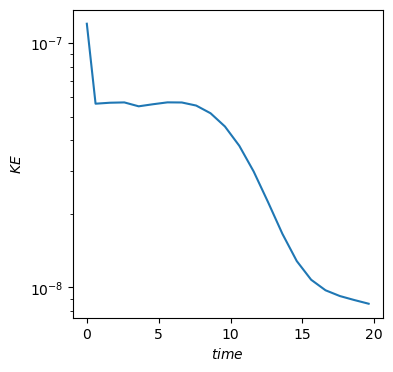

In [23]:
plt.figure(figsize=(4,4))
plt.semilogy(times,KE_list)
plt.xlabel(r'$time$')
plt.ylabel(r'$KE$')

## Other geometries

Very similar to what has been discussed discussed, see the range of Dedalus examples available.